In [1]:
import torch
import torch.nn as nn
import random
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import time
from nnmodels import get_model
from train_eval import train, model_eval

#### Define data augmentations

In [2]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32)),
    transforms.RandomAffine(0, shear=0.2),         # random shear 0.2
    transforms.RandomAffine(0, scale=(0.8, 1.2)),  # random zoom 0.2
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),   
    transforms.RandomVerticalFlip(),     
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32)),
])

In [3]:
train_dataset = torchvision.datasets.ImageFolder(root='train', transform=train_transforms)
valid_dataset = torchvision.datasets.ImageFolder(root='val', transform=test_transform)
test_dataset = torchvision.datasets.ImageFolder(root='test', transform=test_transform)
print(train_dataset.class_to_idx)
reversemapping = {a:b for b,a in train_dataset.class_to_idx.items()}
assert train_dataset.class_to_idx == valid_dataset.class_to_idx == test_dataset.class_to_idx

{'paper': 0, 'rock': 1, 'scissors': 2}


#### Visualizing training data

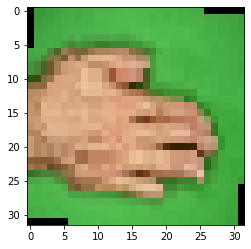

In [4]:
plt.imshow(train_dataset[0][0].permute(1,2,0))

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=256, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

#### Definie Hyper-paramters

In [6]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print('We are using {} for training, note that cpu may be slow for training.'.format(device))
model = get_model('base')
model = model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.001, weight_decay=5e-6)
total_epochs = 20
# scheduler = MultiStepLR(optimizer, milestones=[10,], gamma=0.1)
scheduler = None

We are using cuda for training, note that cpu may be slow for training.


#### Model training

In [7]:
best_val_acc = 0.0
final_test_acc = 0.0
for epoch in range(total_epochs):
    train(model, loss, optimizer, train_loader, device, epoch, False, scheduler=scheduler)
    _, val_acc = model_eval(model, loss, val_loader, device, name= 'Valid')
    _, test_acc = model_eval(model, loss, test_loader, device, name= 'Test')
    if val_acc > best_val_acc:
        print('A better Valid Acc is found: {} with Test Acc {}'.format(val_acc, test_acc))
        best_val_acc = val_acc
        final_test_acc = test_acc
        torch.save(model.state_dict(), 'best_model.ckpt')

Epoch: 0, Train: Top 1 Accuracy: 970/1531 (63.36%), Time Used: 0.23202979167302448 mins
Valid Evaluation: Average loss: 3.2144, Top 1 Accuracy: 109/328 (33.23%)
Test Evaluation: Average loss: 3.1929, Top 1 Accuracy: 109/329 (33.13%)
A better Valid Acc is found: 33.23170731707317 with Test Acc 33.130699088145896
Epoch: 1, Train: Top 1 Accuracy: 1398/1531 (91.31%), Time Used: 0.1014242688814799 mins
Valid Evaluation: Average loss: 0.8969, Top 1 Accuracy: 216/328 (65.85%)
Test Evaluation: Average loss: 0.9810, Top 1 Accuracy: 210/329 (63.83%)
A better Valid Acc is found: 65.85365853658537 with Test Acc 63.829787234042556
Epoch: 2, Train: Top 1 Accuracy: 1453/1531 (94.91%), Time Used: 0.10145630836486816 mins
Valid Evaluation: Average loss: 0.1051, Top 1 Accuracy: 316/328 (96.34%)
Test Evaluation: Average loss: 0.1022, Top 1 Accuracy: 321/329 (97.57%)
A better Valid Acc is found: 96.34146341463415 with Test Acc 97.56838905775076
Epoch: 3, Train: Top 1 Accuracy: 1468/1531 (95.89%), Time Use

#### Model results

In [8]:
print('The best Valid Acc: {}, Test Acc: {}'.format(best_val_acc, final_test_acc))
model.load_state_dict(torch.load('best_model.ckpt'))

The best Valid Acc: 99.6951219512195, Test Acc: 99.3920972644377


<All keys matched successfully>

#### Testing results

We are choosing 259/329 for testing with target: scissors.


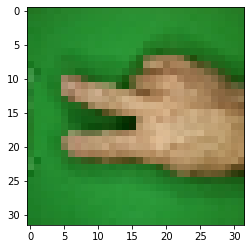

In [9]:
data_len = len(test_dataset)
index = random.randint(0, data_len)
data, target = test_dataset[index]
print('We are choosing {}/{} for testing with target: {}.'.format(index+1, data_len, reversemapping[target]))
plt.imshow(data.permute(1,2,0))

In [10]:
model.eval()
print('Our network prediction is: {}'.format(reversemapping[model(data.unsqueeze(0).cuda()).argmax(1).item()]))

Our network prediction is: scissors
